## Prepare the environment

In [1]:
# !pip install awadb
# !pip install chromadb
# !pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 56.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 9.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 3.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.4/502.4 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 699.2/699.2 kB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 136.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1

## Download Dataset

In [1]:
import os
import pandas as pd

all_dress = pd.read_csv("dress.csv")
all_dress

,_unit_id,category,category:confidence,image_url
0,851505458,ikat,0.3487,http://s3-eu-west-1.amazonaws.com/we-attribute...
1,851505459,plain,1.0000,http://s3-eu-west-1.amazonaws.com/we-attribute...
2,851505460,polka dot,0.6709,http://s3-eu-west-1.amazonaws.com/we-attribute...
3,851505461,plain,1.0000,http://s3-eu-west-1.amazonaws.com/we-attribute...
4,851505462,geometry,0.7035,http://s3-eu-west-1.amazonaws.com/we-attribute...
...,...,...,...,...
15697,854497210,plain,1.0000,http://s3-eu-west-1.amazonaws.com/we-attribute...
15698,854497281,floral,1.0000,http://s3-eu-west-1.amazonaws.com/we-attribute...
15699,854497512,squares,0.9230,http://s3-eu-west-1.amazonaws.com/we-attribute...
15700,854497595,tribal,0.5199,http://s3-eu-west-1.amazonaws.com/we-attribute...


Get first 1000 images

In [4]:
import urllib.request

for ind, row in all_dress.iterrows():
    url = row["image_url"]
    # print(row["image_url"])
    image_id = row["_unit_id"]
    urllib.request.urlretrieve(
        url, os.path.join(os.getcwd(), "dresses/") + str(image_id) + ".png"
    )

    if ind % 100 == 0:
        print(ind)
    if ind >= 1000:
        break

0
100
200
300
400
500
600
700
800
900
1000


### Note

Before proceeding you need to generate textual descriptions of the images using LLaVA. There is a bash script in the repo which should help with that. 

Rest of the notebook assumes both text and image data are present in the same directory with same id.

In [5]:
import uuid

from langchain.embeddings import GPT4AllEmbeddings, HuggingFaceEmbeddings
from langchain.embeddings import AwaEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema.document import Document
from langchain.storage import LocalFileStore, InMemoryStore
from langchain.vectorstores import Chroma
import ipywidgets as widgets

embedding_fn = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
# gtp4all_embedding_fn = GPT4AllEmbeddings()
# multiqa_embedding_fn = HuggingFaceEmbeddings(
#     model_name="sentence-transformers/multi-qa-mpnet-base-dot-v1"
# )

In [6]:
embedding_fn.model_name

'sentence-transformers/all-mpnet-base-v2'

## Load Data
First we load data in memory and check it out before putting into a vector database.

In [9]:
import os
import glob
import numpy as np

text_summaries = glob.glob("/Users/rray/Downloads/data/research/dresses_new/*.txt")
image_files = glob.glob("/Users/rray/Downloads/data/research/dresses_new/*.png")

random_image_idx = np.random.choice(len(image_files), 5, replace=False)

image_widgets = []
for ind in random_image_idx:
    with open(image_files[ind], "rb") as fp:
        image_widgets.append(widgets.Image(value=fp.read(), format="png", width=200))

display(widgets.HBox(image_widgets))

In [11]:
import base64
import io
import os
from io import BytesIO

from langchain.schema.messages import HumanMessage
from PIL import Image


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")
    
id_key = "doc_id"
doc_ids = []
summary_docs = []
img_base64_list = []

for text_path in text_summaries:
    text_f_name = os.path.basename(text_path)
    image_f_name = text_f_name.replace("txt", "png")
    dir_name = os.path.dirname(text_path)
    doc_ids.append(text_f_name.replace(".txt", ""))
    
    with open(text_path, 'r') as text_file:
        original_text = text_file.read()
        desc_text = original_text.split("image patch)")[-1].strip()
        summary_docs.append(desc_text)
    
    base64_image = encode_image(os.path.join(dir_name, image_f_name))
    img_base64_list.append(base64_image)
    

text_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(summary_docs)
]

Filenames without the extension can be used as unique ids (`doc_id`)

In [12]:
doc_ids[:10]

['851506311',
 '851505618',
 '851506305',
 '851506463',
 '851505624',
 '851506339',
 '851505630',
 '851505817',
 '851506113',
 '851506107']

In [13]:
len(img_base64_list), len(summary_docs)

(998, 998)

In [14]:
image_documents = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(img_base64_list)
]

Test a sample image description pair

The image features a woman wearing a black dress with a floral pattern, which is a short dress. She is standing in a garden with a potted plant in the background. The dress can be worn in various situations, such as a casual day out, a garden party, or a summer event. The floral pattern adds a touch of elegance and style to the dress, making it suitable for both formal and informal occasions.


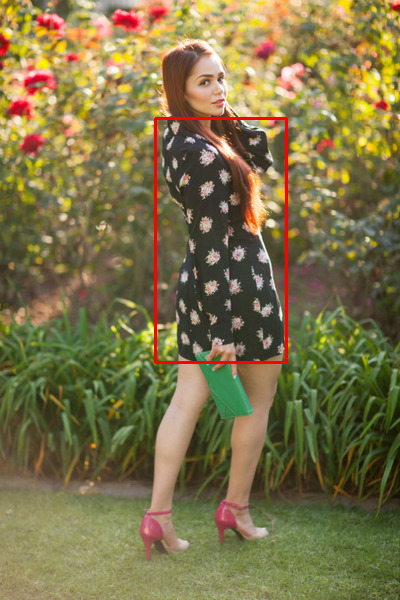

In [15]:
from IPython.display import display

f_index = 48
im = Image.open(BytesIO(base64.b64decode(image_documents[f_index].page_content)))
print(summary_docs[f_index])
display(im)

In [35]:
# vectorstore.delete_collection()

## Build the Retriever
Used Chroma as vector database.
We use a Multi Vector Retriever to store images in doc-store and texts in vector-store.

In [16]:
# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries", embedding_function=embedding_fn)

# The storage layer for the parent documents
store = InMemoryStore()

retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

In [17]:
retriever.vectorstore.add_documents(text_docs)
retriever.docstore.mset(list(zip(doc_ids, image_documents)))

In [18]:
retriever.vectorstore.get(where={"doc_id": "851505469"})

{'ids': ['b54cb382-9d7b-11ee-91e9-acde48001122'],
 'embeddings': None,
 'documents': ['The image features a woman wearing a pink dress, which appears to be a strapless, floor-length gown. The dress is elegant and suitable for various occasions, such as weddings, proms, formal events, or even a night out with friends. The woman is also holding a handbag, which complements her outfit and adds a touch of sophistication to the overall look.'],
 'metadatas': [{'doc_id': '851505469'}]}

In [ ]:
# texts = retriever.vectorstore.similarity_search(query)
# retriever.vectorstore.similarity_search(query)

## Test Retriever

In [20]:
def show_images(docs, show_text=False):
    if show_text:
        for i, sample_doc in enumerate(docs):
            text_desc = retriever.vectorstore.get(
                where={"doc_id": d.metadata["doc_id"]}, include=["documents"]
            )["documents"][0]
            print(text_desc)
    
    image_widgets = [
        widgets.Image(
            value=base64.b64decode(sample_doc.page_content), format="png", width=300
        )
        for sample_doc in docs
    ]
    
    display(widgets.HBox(image_widgets))

# retriever.vectorstore.similarity_search("floor length gown")

# query = "Suggest a stylish dress that I can wear in the sea beaches of Hawaii"
# query = "Suggest strapless floor length gowns that I can wear in my friend's wedding"
query = "Suggest a dress with flowing style having floral pattern"
docs = retriever.get_relevant_documents(query)

show_images(docs)

## Prepare Multimodal RAG

In [21]:
import re

from langchain.schema import Document
from langchain.schema.runnable import RunnableLambda
from langchain.chat_models import ChatOpenAI

def looks_like_base64(sb):
    """Check if the string looks like base64."""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """Check if the base64 data is an image by looking at the start of the data."""
    image_signatures = {
        b"\xFF\xD8\xFF": "jpg",
        b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False

# If we are able to get the image documents, using metadata (doc_id) we can fetch matching texts.
def fetch_texts(docs, top_k=3):
    b64_images = []
    texts = []
    for doc in docs:
        doc_id = doc.metadata["doc_id"]
        text = retriever.vectorstore.get(
            where={"doc_id": doc_id}, include=["documents"]
        )["documents"][0]
        texts.append(text)
        doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            b64_images.append(doc)
    
    
    return {"images": b64_images[:top_k], "texts": texts[:top_k]}

### Define the prompt
**Ensure that `OPENAI_API_KEY` enviornment variable is set before proceeding.**

In [22]:
def img_prompt_func(data_dict):
    # Joining the context texts into a single string
    messages = []
    text_message = {
        "type": "text",
        "text": (
            "You are a dress recommender tasked with assisting women with dress suggestions.\n"
            "You will be given a number of images of dresses and corresponding descriptions.\n"
            "Use this information to provide assistance with attires.\n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Images and their descriptions:\n"
        ),
    }
    messages.append(text_message)

    num_docs = len(data_dict["context"]["texts"])

    # Adding image(s) to the messages if present
    for i, im in enumerate(data_dict["context"]["images"]):
        image_message = {
            "type": "image_url",
            "image_url": {"url": f"data:image/png;base64,{im}"},
        }
        messages.append(image_message)
        desc_text = data_dict["context"]["texts"][i]
        messages.append({"type": "text", "text": desc_text})
    # Adding the text message for analysis

    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """Multi-modal RAG chain"""

    # Multi-modal LLM
    model = ChatOpenAI(
        temperature=0, model="gpt-4-vision-preview", max_tokens=1024
    )

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain

## Dummy RAG Chain
Without the LLM at end we can test what the input to the LLM would look like when we attach it at the end of the chain.

In [23]:
from functools import partial

from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

dummy_chain = (
    {
        "context": retriever | RunnableLambda(partial(fetch_texts, top_k=3)),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(img_prompt_func)
)

In [24]:
dummy_chain

{
  context: MultiVectorRetriever(vectorstore=<langchain.vectorstores.chroma.Chroma object at 0x1359fba00>, docstore=<langchain.storage.in_memory.InMemoryStore object at 0x1359fb9d0>)
           | RunnableLambda(...),
  question: RunnablePassthrough()
}
| RunnableLambda(...)

You are a dress recommender tasked with assisting women with dress suggestions.
You will be given a number of images of dresses and corresponding descriptions.
Use this information to provide assistance with attires.
User-provided question: I'm planning a vacation in Hawaii. Suggest a stylish dress that I can wear in the beaches.

Images and their descriptions:




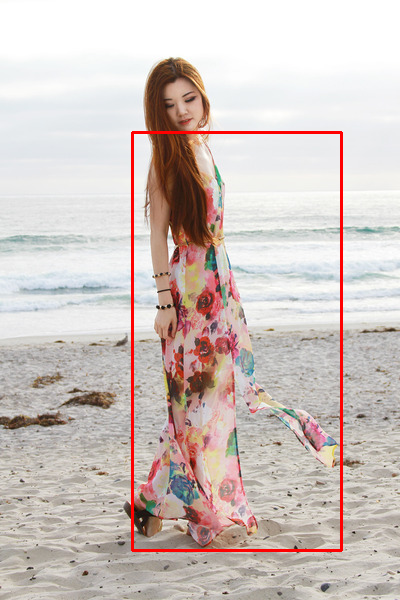

The image features a woman wearing a colorful dress, which is a flowery print dress. The dress is designed to be worn in various situations, such as casual outings, beach outings, or even formal events. The dress's vibrant colors and floral pattern make it a versatile and stylish choice for different occasions. The woman is posing for a picture on the beach, showcasing the dress's suitability for beach outings.



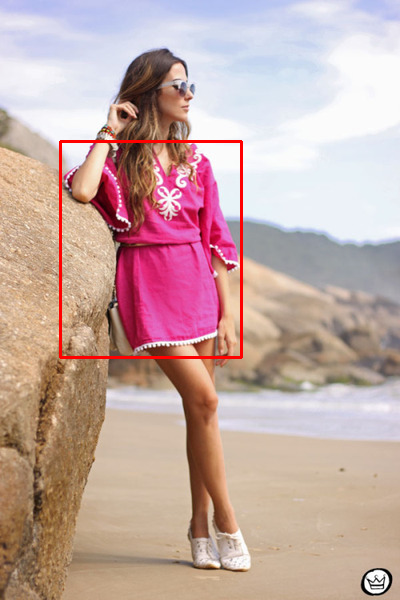

The image features a woman wearing a pink dress, which is a sleeveless, short-sleeved, and ruffled dress. The dress is designed with a floral pattern, adding a touch of elegance to the outfit. The woman is standing on a beach, which is an appropriate setting for this type of dress. This dress can be worn in various situations, such as beach outings, casual gatherings, or even as a stylish addition to a summer wardrobe. The dress's lightweight and comfortable design makes it suitable for warm weather and relaxed environments.



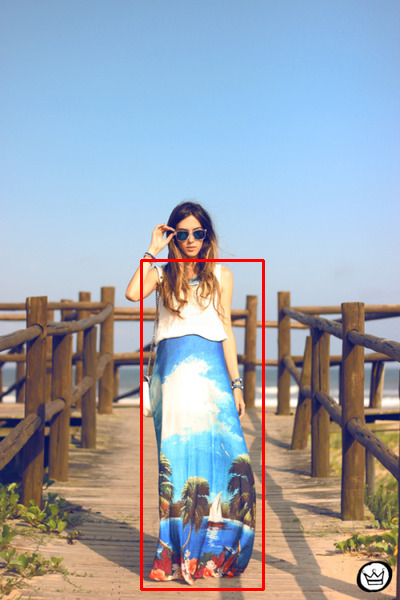

In the image, a woman is wearing a blue dress with a picture of a beach on it. The dress is a flowing, long-sleeved garment that is suitable for various occasions, such as a beach, a casual event, or a vacation. The dress can be worn in different settings, including a beach, a pool party, or a summer gathering, as it is designed to complement the beach theme and provide a comfortable and stylish look.


In [25]:
from IPython.display import display, HTML

sample_docs = dummy_chain.invoke("I'm planning a vacation in Hawaii. Suggest a stylish dress that I can wear in the beaches.")
# sample_docs = dummy_chain.invoke("Suggest a bright dress with floral pattern that I can wear with a handbag and a sunglass")
# sample_docs = dummy_chain.invoke("Suggest a floor length gown that I can wear in my friend's wedding")


for sample in sample_docs[0].content:
    if sample["type"] == "text":
        print(sample["text"])
    else:
        display(HTML("<img alt='img' src='{}'>".format(sample["image_url"]["url"])))

In [100]:
len(sample_docs), len(sample_docs[0].content)

(1, 7)

### Create Full Chain

In [30]:
model = ChatOpenAI(
    temperature=0,
    model="gpt-4-vision-preview",
    max_tokens=1024,
    api_key=os.environ["OPENAI_API_KEY"],
)
top_k = 3
# RAG pipeline
chain = (
    {
        "context": retriever | RunnableLambda(partial(fetch_texts, top_k=top_k)),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(img_prompt_func)
    | model
    | StrOutputParser()
)

## Put it into action

In [31]:
query = "Suggest a stylish dress that I can wear in the sea beaches of Hawaii"

res = chain.invoke(query)
images = retriever.get_relevant_documents(query)
image_widgets = [
    widgets.Image(
        value=base64.b64decode(sample_doc.page_content), format="png", width=300
    )
    for sample_doc in images[:top_k]
]
widgets.HBox(image_widgets)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [32]:
query = "Suggest strapless floor length gowns that I can wear in my friend's wedding"

res = chain.invoke(query)

print(res)
images = retriever.get_relevant_documents(query)
image_widgets = [
    widgets.Image(
        value=base64.b64decode(sample_doc.page_content), format="png", width=300
    )
    for sample_doc in images[:top_k]
]
widgets.HBox(image_widgets)

Based on the images and descriptions provided, it seems you are looking for elegant strapless floor-length gowns suitable for wearing to a friend's wedding. All three dresses depicted are black, backless, and floor-length, which are characteristics that align well with formal wedding attire. Here are some suggestions based on the styles shown:

1. A strapless black floor-length gown with a backless design, similar to the first image, would be a sophisticated choice. Look for a dress with unique back detailing or embellishments to add a touch of glamour.

2. If you prefer a gown with sleeves but still want the backless feature, you might consider a style like the one in the second image. This dress combines the elegance of a long sleeve with the allure of a backless design.

3. For a textured look, you could opt for a strapless floor-length gown with a fabric that has a pattern or texture, as seen in the third image. This adds depth to the dress and can be particularly striking in photo